# <center><font color="red">**Few-Shot Adaptation of Foundation Models for Semantic Segmentation of Semiconductor Defects in SEM Imagery**</font></center>

---
### Last update: 20-02-2025
---

### **Author:**
- **Andrea Turchet - University of Udine**  
- **Mail:  anturchet@edu.aau.at**
---

### **Supervisor:**
- **Prof. Konstantin Schekotihin - University of Klagenfurt**  
- **Mail: konstantin.schekotihin@aau.at**
---

### **Abstract:**

<div style="background-color:#f0f8ff; padding:10px; border-radius:5px; font-size: 14px;">
This research investigates the adaptation and performance of state-of-the-art foundation models for semantic segmentation in specialized industrial domains using few-shot learning approaches. Specifically, we examine the effectiveness of current SOTA models with few-shot learning methodologies for segmenting defects in semiconductor wafer images. Using the Carinthia dataset, which comprises 4,591 Scanning Electron Microscope (SEM) images of semiconductor wafer defects across six distinct classes, we evaluate whether generic segmentation models can be effectively adapted to highly specialized domains with minimal training examples. The main purpose of this study is achieving an accurate semantic segmentation in industrial applications where labeled data is scarce and domain expertise is relevant. The research explores various few-shot learning techniques integrated with foundational segmentation models, analyzing their efficacy in maintaining segmentation accuracy while reducing the requirement for extensive labeled training data.
</div>

---

### **Summary**:

1. [Introduction](#introduction)
2. [Changelog](#changelog)
3. [Dataset and Preprocessing](#dataset)
4. [EDA](#eda)
5. [Models](#models)
6. [Conclusions](#conclusions)


---


<a id="introduction"></a>
## 1. Introduction
<div style="background-color:#f0f8ff; padding:10px; border-radius:5px; font-size: 14px;">
Semantic segmentation is a key task in computer vision, enabling pixel-level understanding and classification of visual content. While this technology has demonstrated good capacities, its traditional implementation faces a relevant challenge: the requirement for extensive datasets with precise, pixel-wise annotations. Getting these labeled images is hard, especially in specific fields where expert knowledge is needed to label the data correctly. To address this limitation, researchers have turned to few-shot learning approaches, giving rise to Few-Shot Segmentation (FSS). This innovative paradigm should achieve accurate segmentation results using only a handful of annotated examples, reducing the data annotation load while maintaining performance. In this research we will try different approach of FSS, benchmarking all of them at the end.

---
</div>

In [1]:
!pip install opencv-python google.generativeai sam2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none

In [3]:
import os
import json
import PIL
from google.colab import userdata
import google.generativeai as genai
import torch
import re
import torchvision
import cv2
import random
import time
from pathlib import Path
from PIL import Image, ImageDraw
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
from scipy.spatial.distance import cdist
from skimage.io import imread, imsave
import numpy as np
from skimage.feature import ORB, match_descriptors
from skimage.feature import plot_matched_features
from google.colab import output
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import AutoProcessor, AutoModelForImageTextToText
from transformers import SegGptImageProcessor, SegGptModel, SegGptForImageSegmentation


%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/data'

Mounted at /content/drive


In [4]:
carinthia_df = pd.read_csv(f'{data_path}/carinthia.csv')

# Split the single column into multiple columns based on the semicolon separator
df_split = carinthia_df['image_path;file_name;label'].str.split(';', expand=True)
df_split.columns = ['image_path', 'file_name', 'label']

In [5]:
# Checking for missing and duplicate data
missing_data = df_split.isnull().sum()
duplicate_data = df_split.duplicated().sum()

# Distribution of labels
label_distribution = df_split['label'].value_counts()

print("Missing Data:\n", missing_data)
print("\nDuplicate Data:", duplicate_data)
print("\nLabel Distribution:\n", label_distribution)

Missing Data:
 image_path    0
file_name     0
label         0
dtype: int64

Duplicate Data: 0

Label Distribution:
 label
3    4008
4     289
6     227
1      55
2       8
5       4
Name: count, dtype: int64


In [ ]:
def show_label_examples(df_split, data_path):
    """
    Displays an example image for each unique label in the dataset.

    Parameters:
    df_split (pandas.DataFrame): DataFrame containing the 'label' column
    data_path (str): Path to the directory containing the image files
    """
    # Get unique labels
    unique_labels = df_split['label'].unique()

    # Set up the figure
    fig, m_axs = plt.subplots(1, len(unique_labels), figsize=(5 * len(unique_labels), 5))
    if not isinstance(m_axs, np.ndarray):
        m_axs = [m_axs]

    # Iterate through each unique label
    for i, label in enumerate(unique_labels):
        # Find the first image with the current label
        example_row = df_split[df_split['label'] == label].iloc[0]
        img_path = os.path.join(data_path, 'images', example_row['file_name'])

        # Load and display the image
        img = Image.open(img_path)
        m_axs[i].imshow(img)
        m_axs[i].set_title(label)
        m_axs[i].axis('off')

    plt.show()


def show_examples_for_label(df_split, data_path, label, num_examples=3):
    """
    Displays a few example images for a specific label.

    Parameters:
    df_split (pandas.DataFrame): DataFrame containing the 'label' and 'image_path' columns
    data_path (str): Path to the directory containing the image files
    label (str or int): The label to display examples for
    num_examples (int): Number of examples to display (default is 3)
    """
    # Ensure labels are numeric if possible
    try:
        df_split['label'] = df_split['label'].astype(int)
        label = int(label)  # Convert input label to int if labels are numeric
    except ValueError:
        pass  # Skip conversion if labels are non-numeric strings

    # Filter the DataFrame for the specified label
    label_df = df_split[df_split['label'] == label]
    print(f"Number of examples found for label '{label}': {len(label_df)}")

    # Check if there are enough examples
    if len(label_df) < num_examples:
        print(f"Only {len(label_df)} examples available for label '{label}', displaying all.")
        num_examples = len(label_df)

    # Randomly select the specified number of examples
    selected_rows = label_df.sample(num_examples, random_state=42)

    # Set up the figure
    fig, m_axs = plt.subplots(1, num_examples, figsize=(5 * num_examples, 5))
    if not isinstance(m_axs, np.ndarray):
        m_axs = [m_axs]

    # Display each selected image
    for ax, (_, row) in zip(m_axs, selected_rows.iterrows()):
        img_path = os.path.join(data_path, 'images', row['file_name'])

        # Load and display the image
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"{label}")
        ax.axis('off')

    plt.show()

Example images for each label:


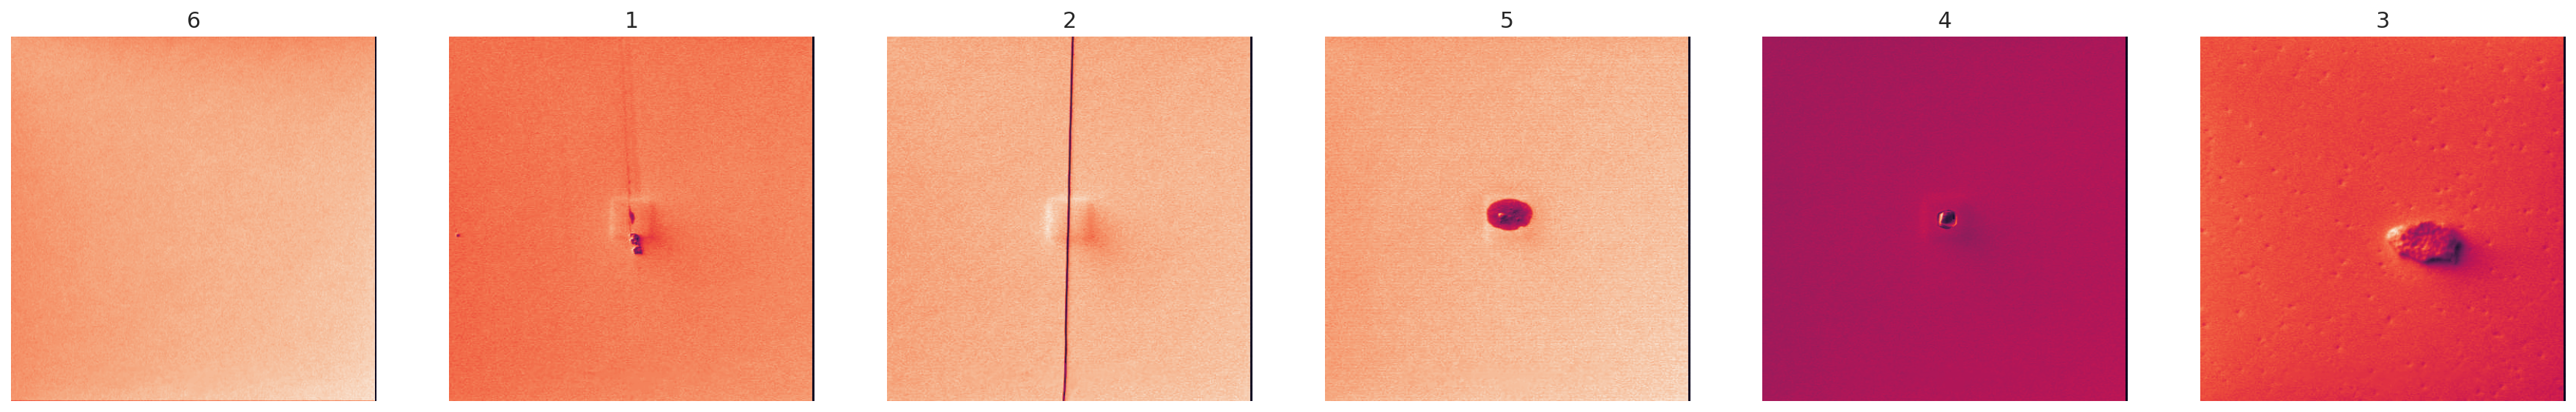

In [ ]:
# print an example of each label
print("Example images for each label:")
show_label_examples(df_split, data_path)

MASKS

In [ ]:
# code for apply the mask to the images

# path
data_path = '/content/drive/MyDrive/data'
image_dir = Path(data_path) / 'images'
ann_dir = Path(data_path) / 'annotations'
mask_dir = Path(data_path) / 'mask'


for ann_path in ann_dir.glob('*.json'):
    image_name = ann_path.stem

    image_path = image_dir / f'{image_name}.jpg'

    if image_path.exists():
        try:

            image = Image.open(image_path).convert('RGB')

            with open(ann_path, 'r') as f:
                mask_data = json.load(f)

            image_key = list(mask_data.keys())[0]
            image_data = mask_data[image_key]

            mask_image = Image.new('L', image.size, 0)
            draw = ImageDraw.Draw(mask_image)

            for region in image_data['regions']:
                shape_attributes = region['shape_attributes']
                if shape_attributes['name'] == 'polygon':
                    polygon_points = list(zip(shape_attributes['all_points_x'],
                                              shape_attributes['all_points_y']))
                    draw.polygon(polygon_points, fill=255)
                elif shape_attributes['name'] == 'circle':
                     cx, cy, r = shape_attributes['cx'], shape_attributes['cy'], shape_attributes['r']
                     circle_bbox = [(cx - r, cy - r), (cx + r, cy + r)]
                     draw.ellipse(circle_bbox, fill=255)

            mask_image.save(mask_dir / f'{image_name}.png')

        # hande exceptions for file not found or processing the mask
        except KeyError as e:
            print(f"Error processing mask file: {ann_path}, KeyError: {e}")
        except Exception as e:
            print(f"Error processing mask file: {ann_path}, Error: {e}")

    else:
        print(f"Image file not found for mask: {ann_path}")

print("Mask PNG files generated and saved in the 'mask' folder.")

Mask PNG files generated and saved in the 'mask' folder.


Mask file not found: /content/drive/MyDrive/data/mask/2661734b21874fdf9e35a4319a9e7462.png


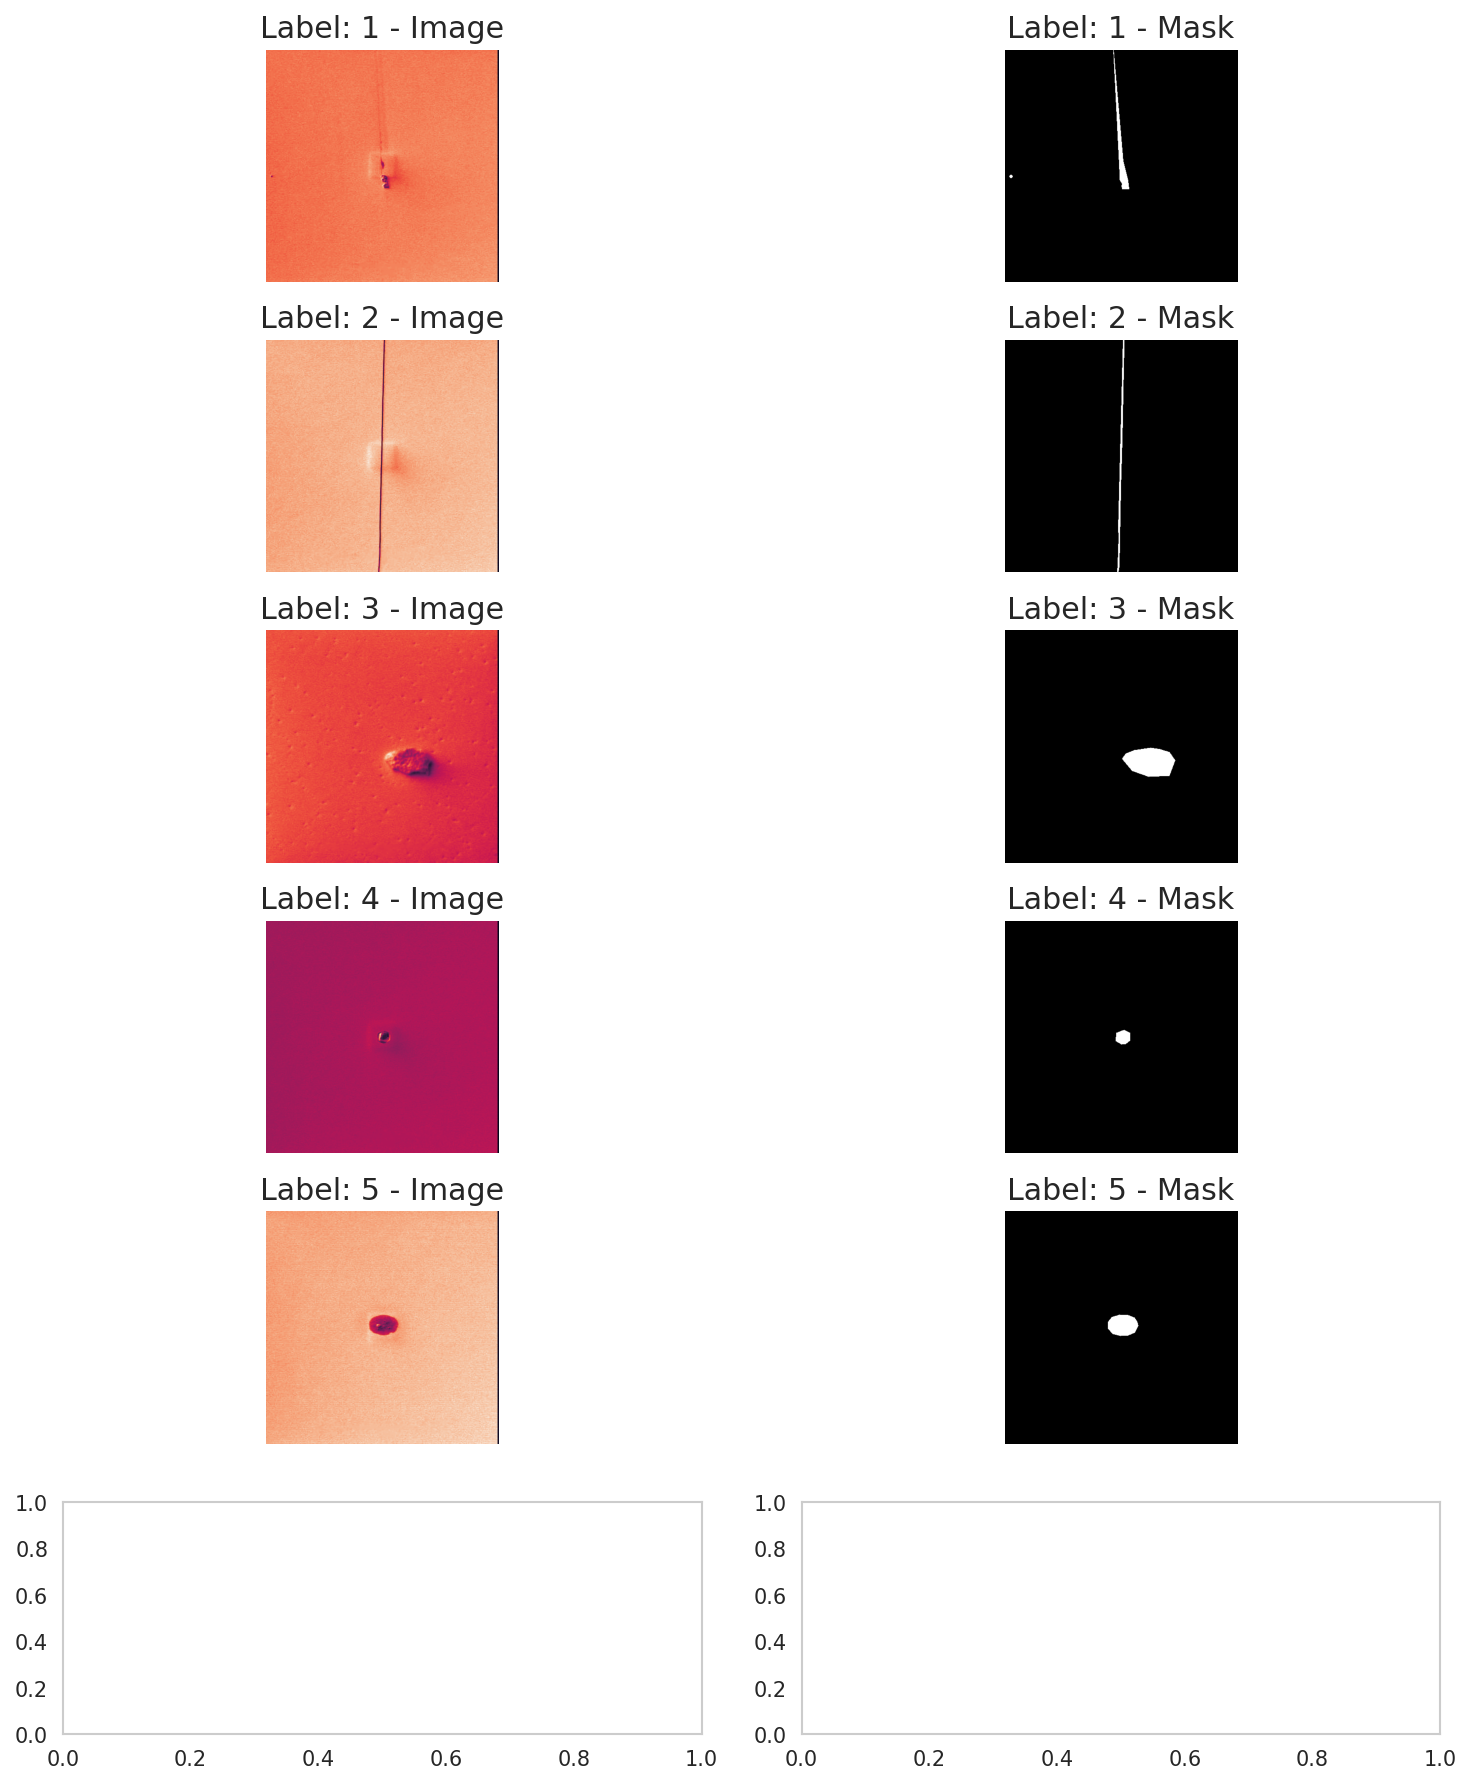

In [ ]:
#code for visualize the plot
df_split['image_path'] = df_split['file_name'].apply(lambda x: (image_dir / x).resolve())
grouped_images = df_split.groupby('label').first().reset_index()

fig, axes = plt.subplots(len(grouped_images), 2, figsize=(10, 2 * len(grouped_images)))

# Iterate through the grouped images and plot them
for i, row in grouped_images.iterrows():
    label = row['label']
    image_filename = row['file_name']

    # Construct the full paths to the image and its mask (now simpler)
    image_path = Path(row['image_path'])
    mask_filename = image_filename.replace('.jpg', '.png')
    mask_path = mask_dir / mask_filename

    # Check
    if not image_path.exists():
        print(f"Image file not found: {image_path}")
        continue
    if not mask_path.exists():
        print(f"Mask file not found: {mask_path}")
        continue

    img = Image.open(image_path)
    mask = Image.open(mask_path)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Label: {label} - Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Label: {label} - Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# SAM2 IMPLEMENTATION WITH VLM API CALL FOR DETECTING BBOXs

In [26]:
def parse_bounding_box(response):
    bounding_boxes = re.findall(r'\[(\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\w\s]+)\]', response)

    # Convert each group into a list of integers and labels.
    parsed_boxes = []
    for box in bounding_boxes:
        parts = box.split(',')
        numbers = list(map(int, parts[:-1]))
        label = parts[-1].strip()
        parsed_boxes.append((numbers, label))

    # Return the list of bounding boxes with their labels.
    return parsed_boxes


def draw_bounding_boxes(image, bounding_boxes_with_labels):
    label_colors = {}
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = np.array(image)

    coordinates = []

    for bounding_box, label in bounding_boxes_with_labels:

        # Normalize the bounding box coordinates
        width, height = image.shape[1], image.shape[0]
        ymin, xmin, ymax, xmax = bounding_box
        x1 = int(xmin / 1000 * width)
        y1 = int(ymin / 1000 * height)
        x2 = int(xmax / 1000 * width)
        y2 = int(ymax / 1000 * height)

        coordinates = [x1, y1, x2, y2]

        if label not in label_colors:
            color = np.random.randint(0, 256, (3,)).tolist()
            label_colors[label] = color
        else:
            color = label_colors[label]

        color = (254, 4, 141)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        box_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_size[1] - 5
        text_bg_x2 = x1 + text_size[0] + 8
        text_bg_y2 = y1

        #cv2.rectangle(image, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        #cv2.putText(image, label, (x1 + 2, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, box_thickness)

    image = PIL.Image.fromarray(image)
    return image, coordinates

In [30]:
def detect_bounding_boxes_with_gemini(input_image_path, object_to_detect='defect', data_path='/content/drive/MyDrive/data'):
    """
    Detects bounding boxes of objects in an image using Google Gemini API.

    Args:
        input_image_path: Path to the input image.
        object_to_detect: The name of the object to detect (default: 'defect').
        data_path: Path to the data directory (default: '/content/drive/MyDrive/data').

    Returns:
        A tuple containing:
            - output_image: The image with bounding boxes drawn.
            - coordinates: A list of bounding box coordinates.
    """

    sec = userdata.get('GOOGLE_API_KEY')

    img = Image.open(input_image_path)

    genai.configure(api_key=sec)
    model = genai.GenerativeModel(model_name='gemini-1.5-pro')

    response = model.generate_content([
        img,
        (
            f"Detect the tight 2D bounding box of the {object_to_detect}"
            "Return the coordinates in the format: [ymin, xmin, ymax, xmax, object_name]."
        ),
    ])
    result = response.text
    print(result)

    bounding_box = parse_bounding_box(result)
    output_image, coordinates = draw_bounding_boxes(img, bounding_box)

    return  coordinates

In [31]:
def perform_sam2_segmentation(input_image_path, annotation="Automatic"):
    """
    Performs semantic segmentation using SAM2.

    Args:
        input_image_path: Path to the input image.
        annotation: Annotation type ("Automatic" for center point prompt).

    Returns:
        The predicted segmentation mask as a PyTorch tensor.
    """
    # 1. Get bounding box coordinates from Gemini
    gemini_bbox_coordinates = detect_bounding_boxes_with_gemini(input_image_path)


    # 2. Load input image
    image_data = Image.open(input_image_path).convert("RGB")
    width, height = image_data.size

    # 3. Check if Gemini returned coordinates, otherwise use center point
    if gemini_bbox_coordinates:
        x1, y1, x2, y2 = gemini_bbox_coordinates
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
    else:
        center_x = width // 2  # Use center of image if no coordinates
        center_y = height // 2

    # 4. Load pre-trained SAM2 model
    predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large", device="cuda")

    # 5. Set image and predict masks
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        predictor.set_image(image_data)
        input_point = np.array([[center_x, center_y]])
        input_label = np.ones(input_point.shape[0])
        input_prompts = {
            'point_coords': input_point,
            'point_labels': input_label,
            'multimask_output': False
        }

        masks, scores, logits = predictor.predict(**input_prompts)

    predicted_mask = masks[0]
    return predicted_mask

- [294, 255, 711, 756, rock]



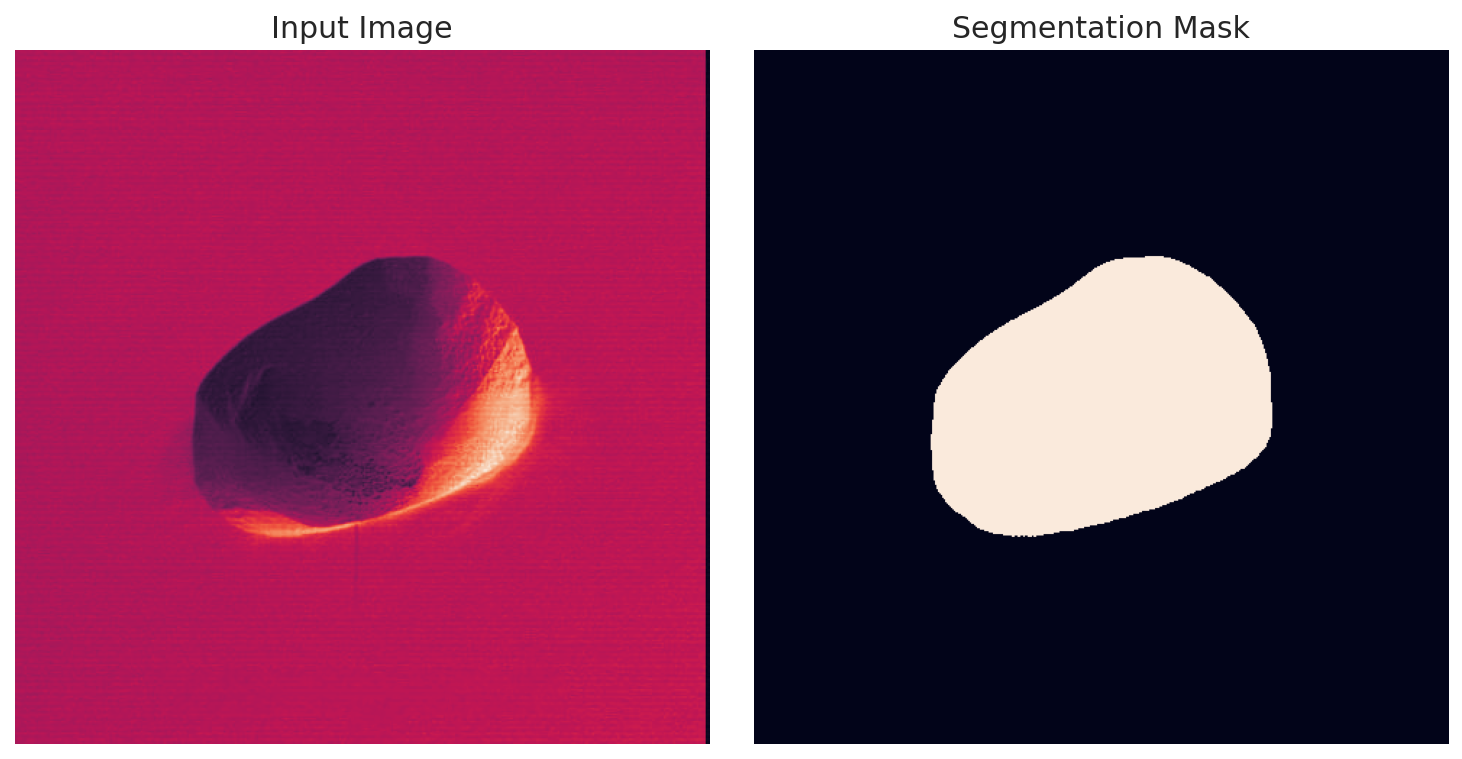

In [32]:
data_path = '/content/drive/MyDrive/data'
input_image_path = os.path.join(data_path, 'seggpt', 'input_image.png')

predicted_mask = perform_sam2_segmentation(input_image_path)

#Visualize
segmented_image_np = np.array(predicted_mask)
input_image = Image.open(input_image_path)
input_image_np = np.array(input_image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image_np)
plt.title("Segmentation Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

# SegGPT

In [20]:
def perform_seggpt_segmentation(input_image_path, prompt_image_path, prompt_mask_path, checkpoint="BAAI/seggpt-vit-large"):
    """
    Performs semantic segmentation using SegGPT.

    Args:
        input_image_path: Path to the input image.
        prompt_image_path: Path to the prompt image.
        prompt_mask_path: Path to the prompt mask.
        checkpoint: The SegGPT checkpoint to use (default: "BAAI/seggpt-vit-large").

    Returns:
        The predicted segmentation mask as a PyTorch tensor.
    """
    # 1. Load images
    prompt_image = Image.open(prompt_image_path).convert("RGB")
    prompt_mask = Image.open(prompt_mask_path).convert("L")
    input_image = Image.open(input_image_path).convert("RGB")

    # 2. Load pre-trained model and processor
    image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
    model = SegGptForImageSegmentation.from_pretrained(checkpoint)

    # 3. Prepare inputs
    inputs = image_processor(
        images=input_image,
        prompt_images=prompt_image,
        prompt_masks=prompt_mask,
        return_tensors="pt"
    )

    # 4. Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # 5. Post-process to get segmentation masks
    target_sizes = [input_image.size[::-1]]
    segmentation_masks = image_processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

    return segmentation_masks[0].cpu().numpy()

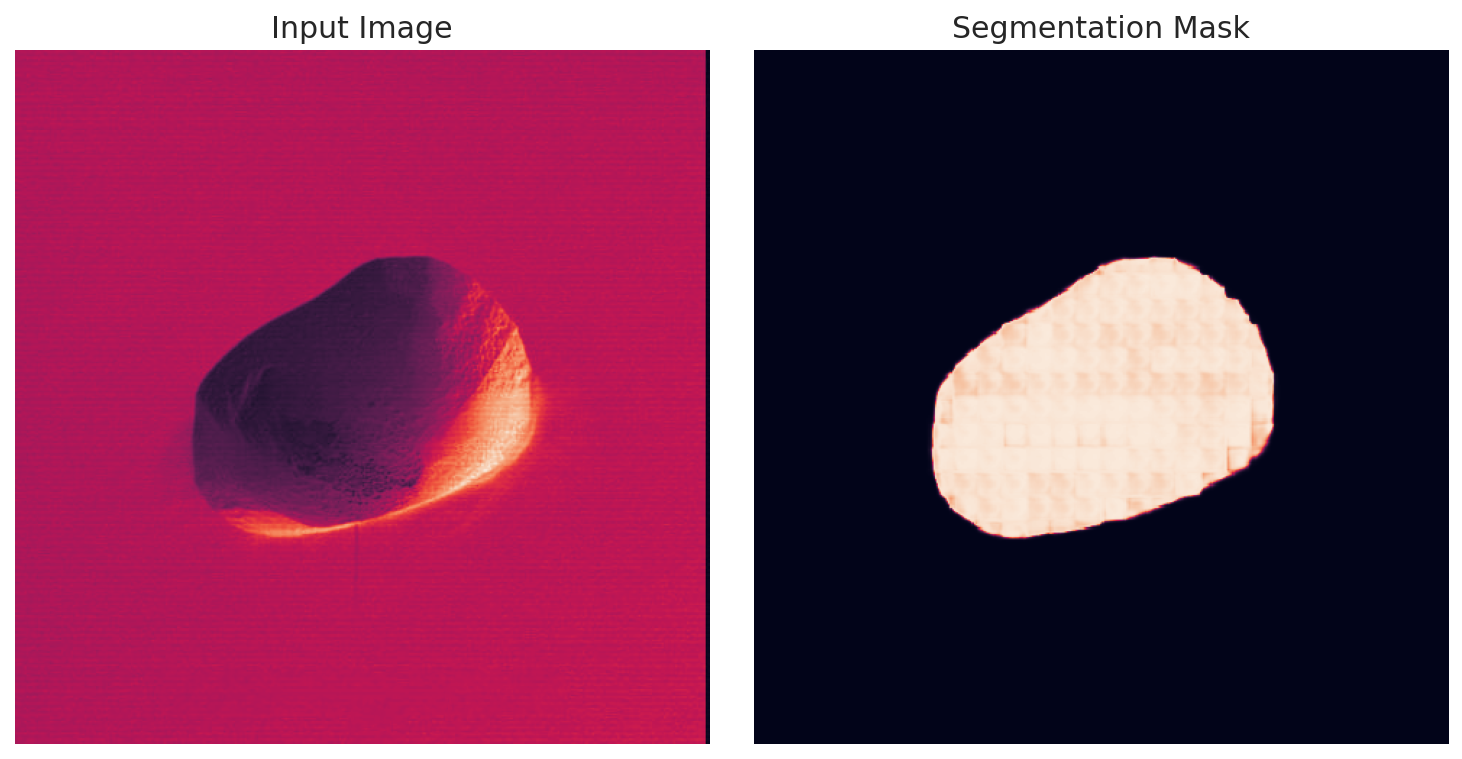

In [ ]:
data_path = '/content/drive/MyDrive/data'
input_image_path = os.path.join(data_path, 'seggpt', 'input_image.png')
prompt_image_path = os.path.join(data_path, 'seggpt', 'prompt_image_1.png')
prompt_mask_path = os.path.join(data_path, 'seggpt', 'prompt_mask_1.png')

predicted_mask = perform_seggpt_segmentation(input_image_path, prompt_image_path, prompt_mask_path)

# Visualize
segmented_image_np = np.array(predicted_mask)
input_image = Image.open(input_image_path)
input_image_np = np.array(input_image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image_np)
plt.title("Segmentation Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

KeyboardInterrupt: 

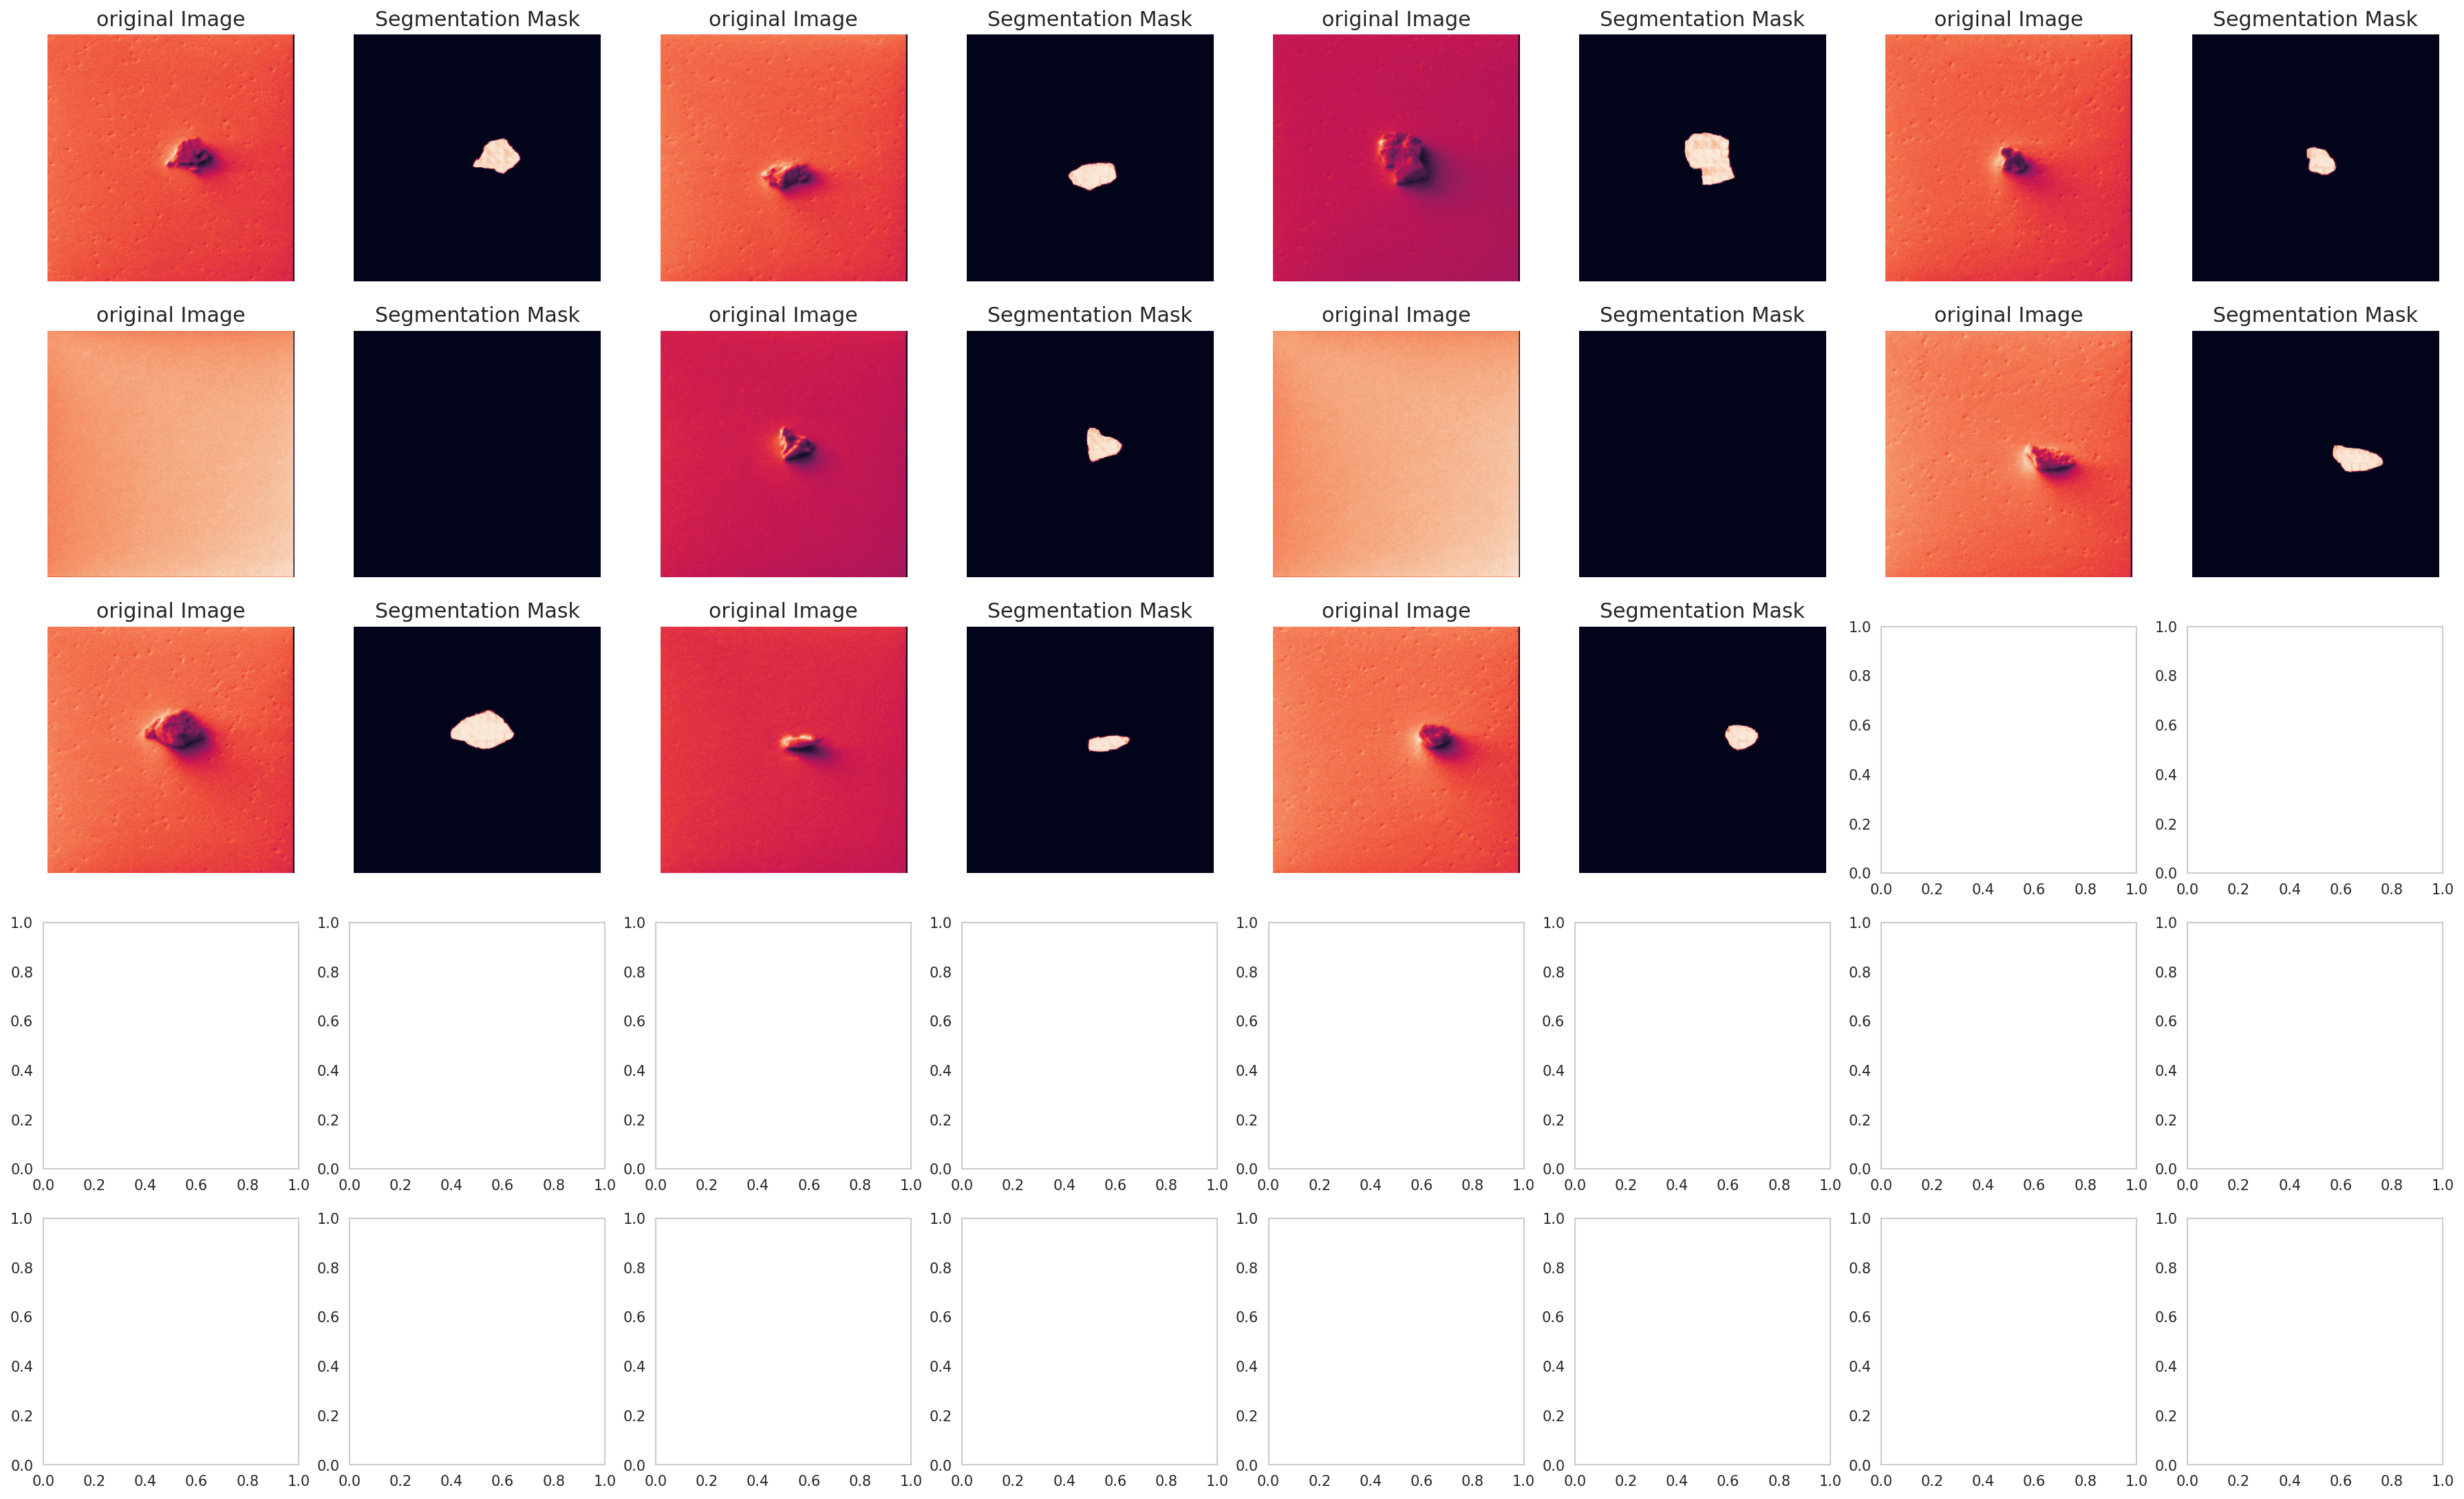

In [21]:
#take 20 random images and perfom the segmentation task
# --- 1. Random Image Selection ---
num_images = 20
num_cols = 8
num_rows = 5
random_images = df_split.sample(n=num_images)

# --- 2. Prompt Image (Use a single representative prompt) ---
prompt_image_path = os.path.join(data_path, 'seggpt', 'prompt_image_1.png')
prompt_mask_path = os.path.join(data_path, 'seggpt', 'prompt_mask_1.png')

# --- 3. Segmentation and Display ---
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 18))

image_index = 0

for i in range(num_rows):
    for j in range(0, num_cols, 2):
        # --- Process Original Image ---
        row = random_images.iloc[image_index]
        image_path = os.path.join(data_path, 'images', row['file_name'])

        # Call the perform_seggpt_segmentation function
        predicted_mask = perform_seggpt_segmentation(image_path, prompt_image_path, prompt_mask_path)
        original_image = Image.open(image_path)
        # Display original and segmented images
        axes[i, j].imshow(original_image)
        axes[i, j].set_title(f"original Image")
        axes[i, j].axis('off')

        axes[i, j + 1].imshow(predicted_mask)
        axes[i, j + 1].set_title("Segmentation Mask")
        axes[i, j + 1].axis('off')

        image_index += 1

plt.tight_layout()
plt.show()

#A possible quantitative evaluation
The core of the following method involves extracting contours, which represent the boundaries of objects or regions, from both the original image and the predicted segmentation mask, and then calculating metrics that quantify the degree of agreement between these two sets of contours.

In [37]:
def detect_and_compare_contours(image_path, segmentation_mask_path):
    """
    Detects contours of the original image and a segmentation mask (predicted),
    calculates metrics comparing their contours, and displays the results.
    """

    try:
        # --- Load Images ---
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load prompt in grayscale
        segmentation_mask = cv2.imread(segmentation_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or segmentation_mask is None:
            raise ValueError("Could not load images. Please check the file paths.")

        # --- Process Original Image ---
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        _, thresh_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((3, 3), np.uint8)
        thresh_image = cv2.dilate(thresh_image, kernel, iterations=1)
        contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter image contours by area
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
        contour_mask = np.zeros_like(image)
        cv2.drawContours(contour_mask, filtered_contours, -1, 255, thickness=1)

        # --- Process Segmentation Mask ---
        contours_segmentation, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        segmentation_contour_mask = np.zeros_like(segmentation_mask)
        cv2.drawContours(segmentation_contour_mask, contours_segmentation, -1, 255, thickness=1)

        # --- Calculate Metrics ---
        if filtered_contours:
            coords = np.vstack([
                np.column_stack(np.where(cv2.drawContours(np.zeros_like(image), [cnt], -1, 255, thickness=1) > 0))
                for cnt in filtered_contours
            ])
        else:
            coords = np.array([])

        if contours_segmentation:
            segmentation_coords = np.vstack([
                np.column_stack(np.where(cv2.drawContours(np.zeros_like(segmentation_mask), [cnt], -1, 255, thickness=1) > 0))
                for cnt in contours_segmentation
            ])
        else:
            segmentation_coords = np.array([])

        # Calculate average distance
        if coords.size > 0 and segmentation_coords.size > 0:
            distances = cdist(segmentation_coords, coords, metric='euclidean')
            avg_distance = np.mean(np.min(distances, axis=1))
        else:
            avg_distance = float('inf')

        # Calculate overlap
        segmentation_area = np.sum(segmentation_contour_mask > 0)
        overlap = (np.sum((contour_mask > 0) & (segmentation_contour_mask > 0)) / segmentation_area * 100) if segmentation_area > 0 else 0.0

        # --- Display Results ---
        print(f"Average Distance: {avg_distance:.2f}")
        print(f"Overlap Percentage: {overlap:.2f}%")

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Original Image Contours")
        plt.imshow(contour_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Segmentation Mask Contours")
        plt.imshow(segmentation_contour_mask, cmap='gray')
        plt.axis('off')

        # Combined image
        combined_image = np.zeros_like(image)
        combined_image[contour_mask > 0] = 128
        combined_image[segmentation_contour_mask > 0] = 255

        plt.subplot(1, 3, 3)
        plt.title("Combined Contours")
        plt.imshow(combined_image, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

Average Distance: 2.59
Overlap Percentage: 16.59%


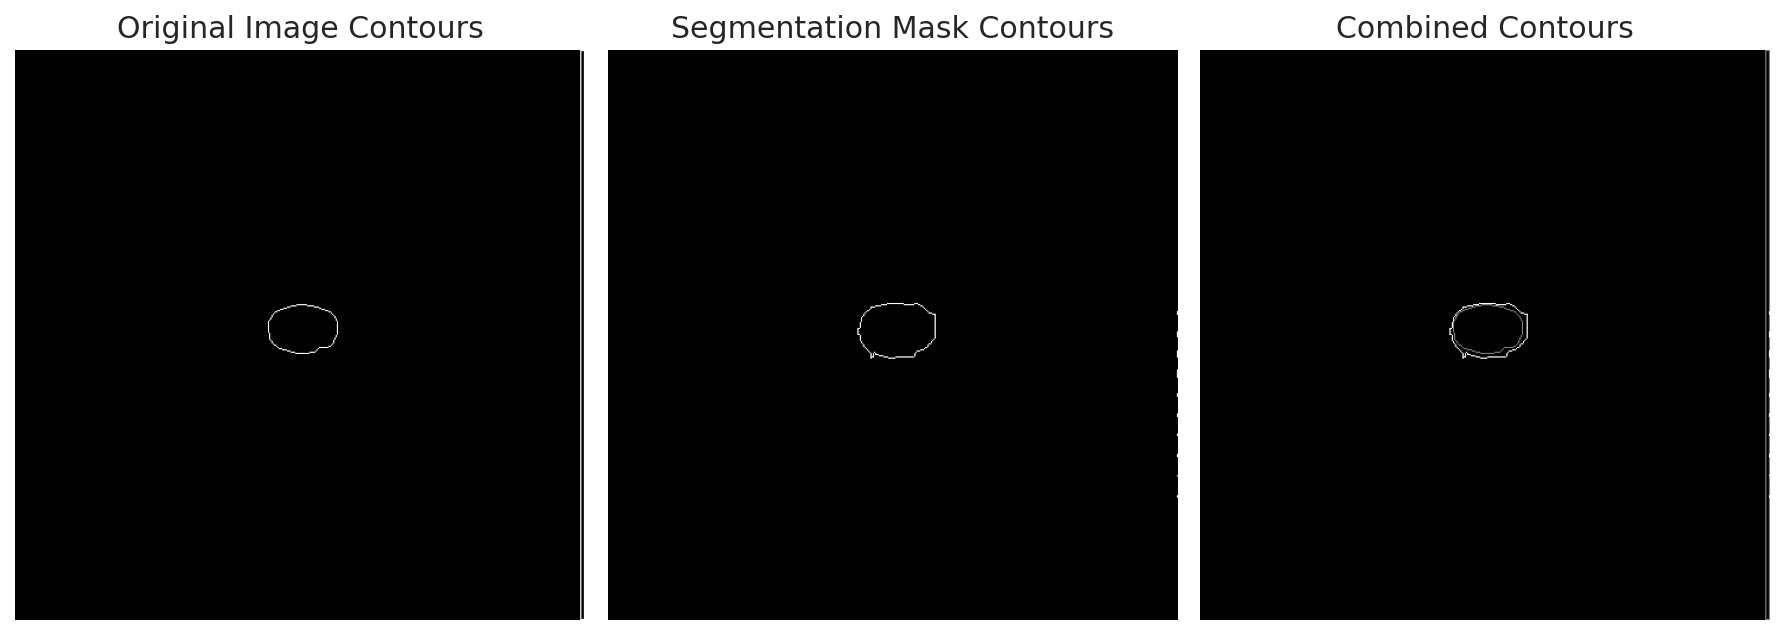

In [ ]:
data_path = '/content/drive/MyDrive/data'
prompt_image_path = os.path.join(data_path, 'images', '0ef66cd9512e4feaa62e4ec3cb75cdc1.jpg')
segmentation_mask_path = os.path.join(data_path, 'seggpt', 'predicted_mask.png')

detect_and_compare_contours(prompt_image_path, segmentation_mask_path)

#Comparison between SAM2 and SegGPT
It can be usueful a quick comparison between 2 models, in the segmentation of 10 randoms selected images

I found the following defects:
- [436, 459, 588, 691, defect]

Here are the objects that I've found:
- [464, 480, 533, 532, defect]

- [385, 448, 557, 598, defect]

- [411, 382, 535, 575, defect]
- [472, 492, 567, 604, defect]



TimeoutException: Requesting secret GOOGLE_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

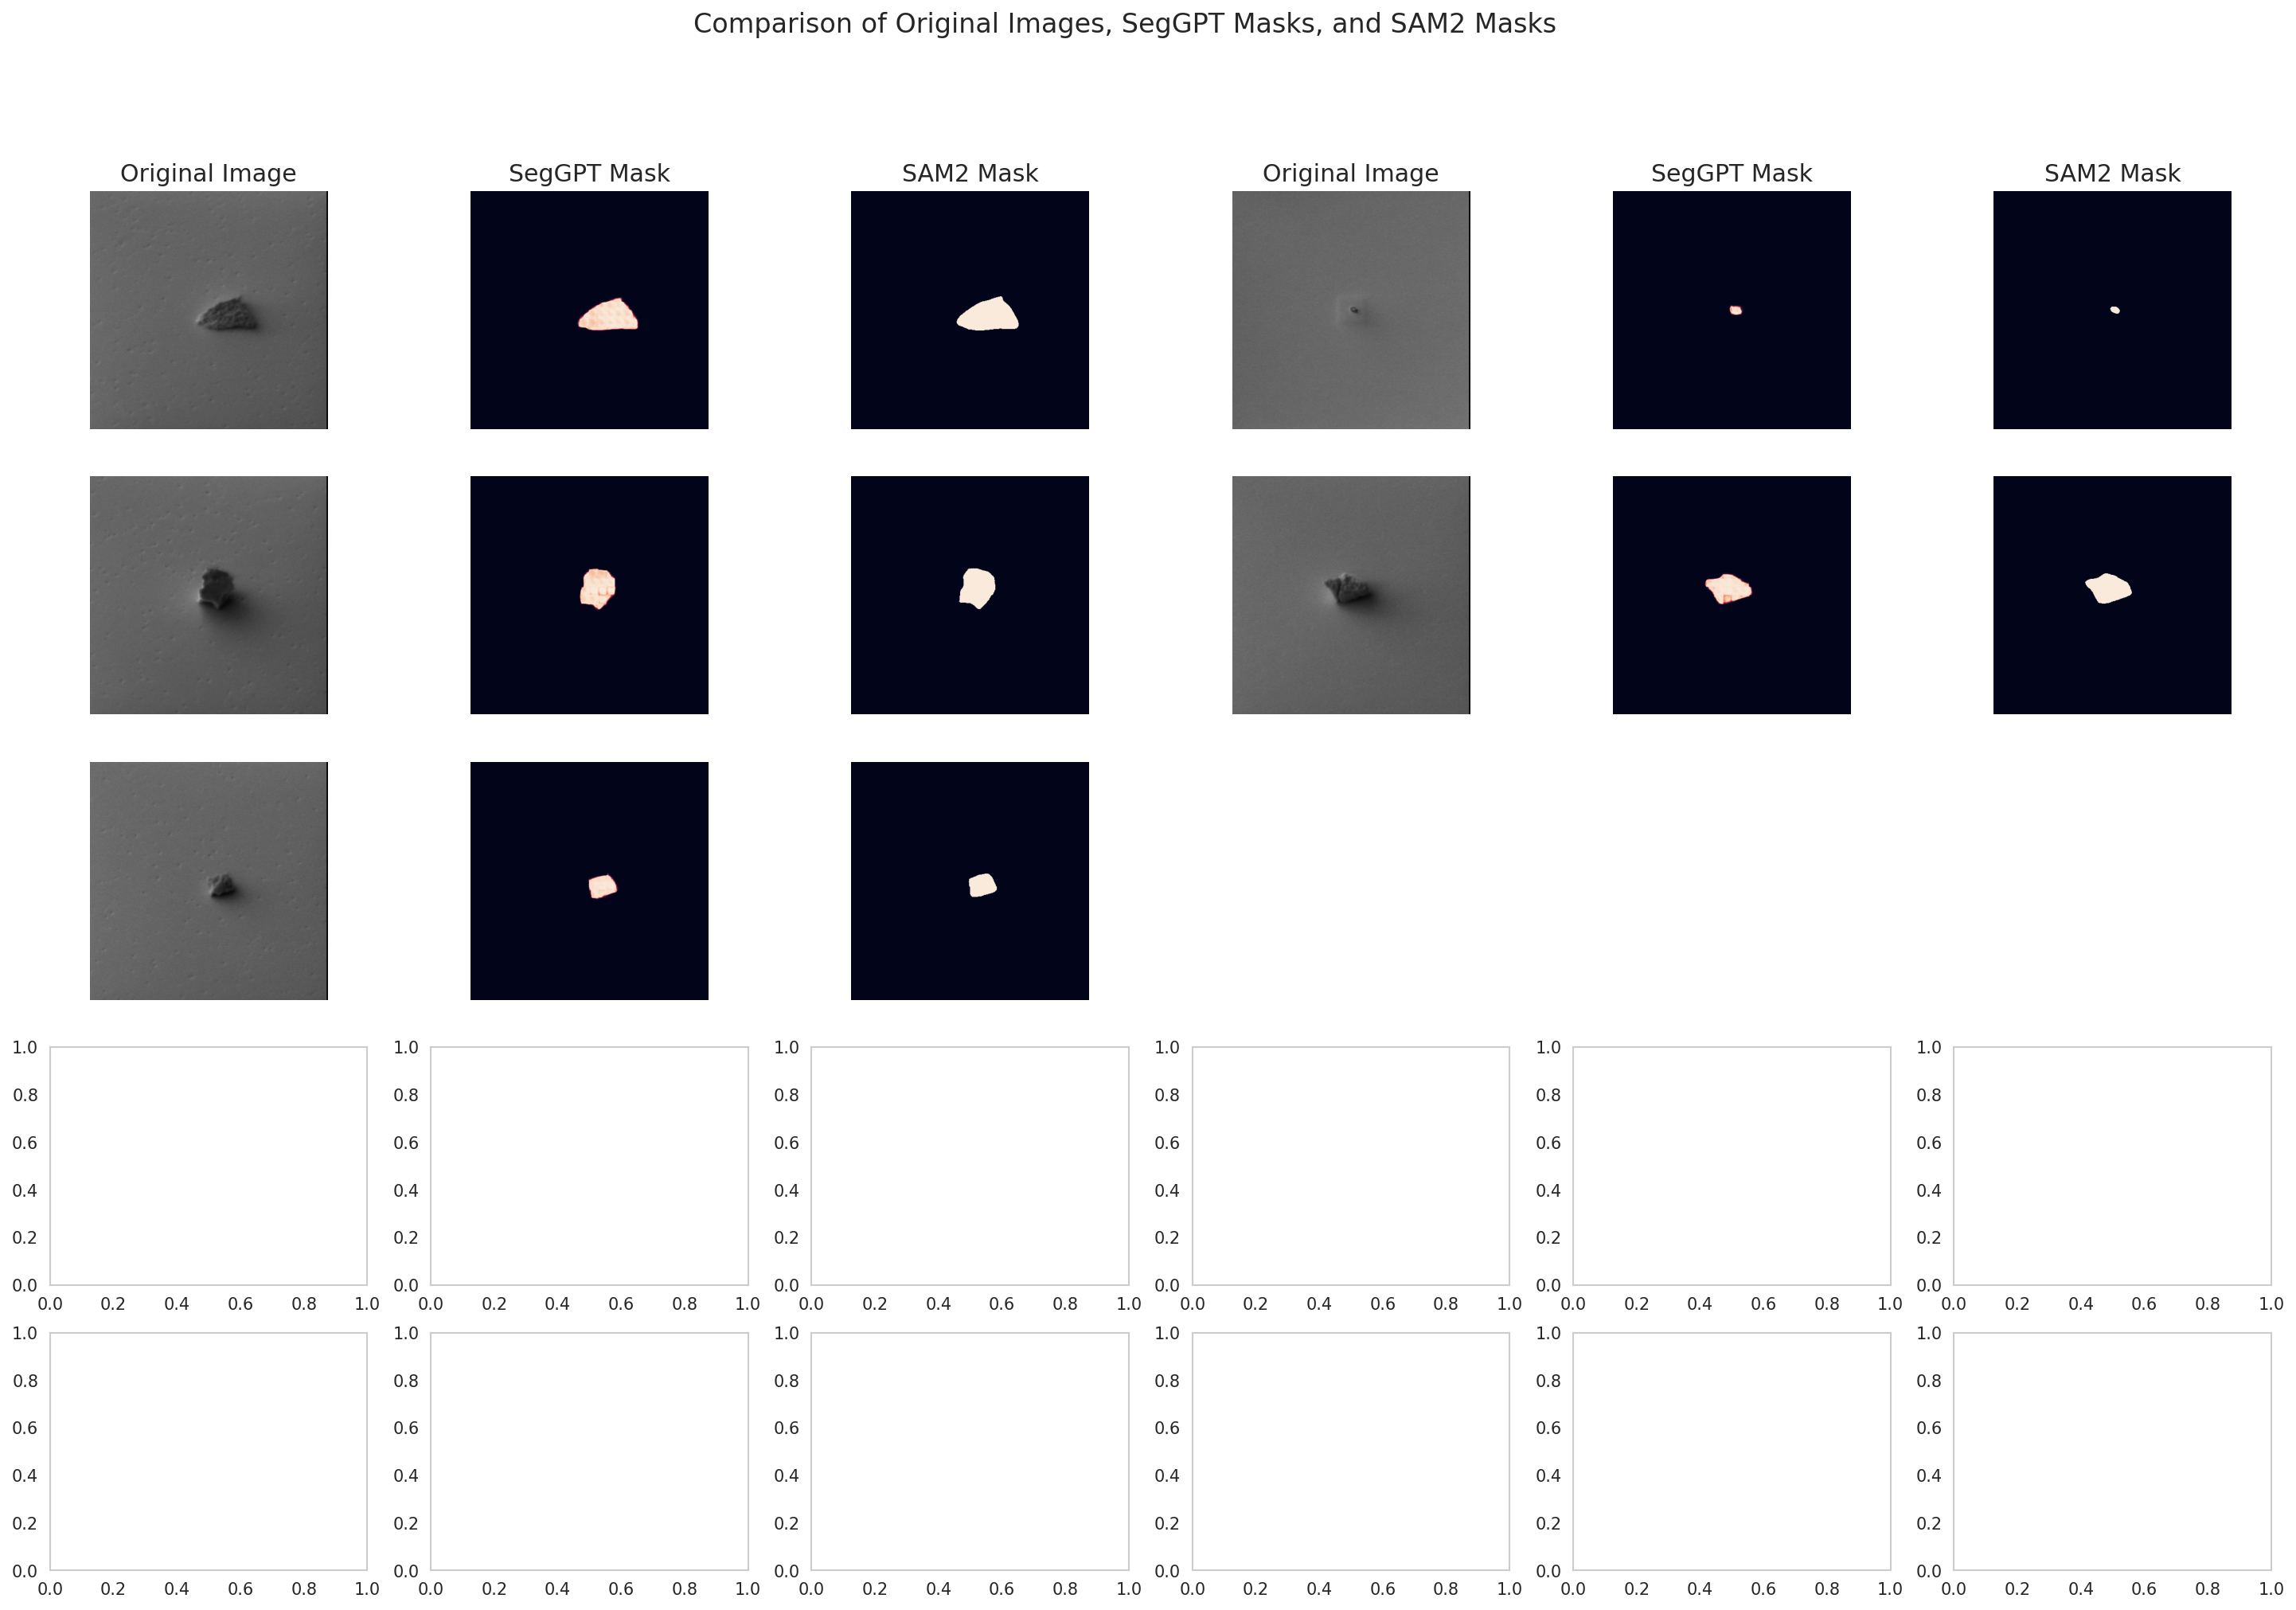

In [40]:
# SAM2 masks vs SegGPT masks
# --- 1. Setup ---
data_path = '/content/drive/MyDrive/data'
images_dir = os.path.join(data_path, 'images')
seggpt_dir = os.path.join(data_path, 'seggpt')
bbox_dir = os.path.join(data_path, 'bbox')
mask_images_dir = Path(data_path) / 'mask_images'

os.makedirs(seggpt_dir, exist_ok=True)
os.makedirs(bbox_dir, exist_ok=True)
mask_images_dir.mkdir(parents=True, exist_ok=True)

# --- 2. Select 10 Random Images ---
image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
if not image_files:
    raise FileNotFoundError(f"No image files found in {images_dir}")

random_image_files = random.sample(image_files, min(10, len(image_files)))

# --- 3. Prepare Figure and Axes Grid (5 rows, 6 columns) ---
fig, axes = plt.subplots(5, 6, figsize=(24, 15))
plt.suptitle("Comparison of Original Images, SegGPT Masks, and SAM2 Masks", fontsize=16)

# --- 4. Process each image and plot in the grid ---
for i, image_file in enumerate(random_image_files):
    input_image_path = os.path.join(images_dir, image_file)
    original_image = PIL.Image.open(input_image_path).convert("RGB")
    img_array = np.array(original_image)
    if img_array.ndim == 2:
        img_array = np.stack([img_array] * 3, axis=-1)

    # --- 5. SegGPT Mask Generation ---
    prompt_image_path = os.path.join(seggpt_dir, 'prompt_image_1.png')
    prompt_mask_path = os.path.join(seggpt_dir, 'prompt_mask_1.png')

    # Call perform_seggpt_segmentation
    seggpt_predicted_mask = perform_seggpt_segmentation(input_image_path, prompt_image_path, prompt_mask_path)
    # --- 6. SAM2 Mask Generation ---
    sam2_predicted_mask = perform_sam2_segmentation(input_image_path)

    # --- 7. Plotting in the Grid (5x6) ---
    row_index = i // 2
    col_start_index = (i % 2) * 3
    ax_row = axes[row_index] # Access the axes for the current row

    ax_row[col_start_index].imshow(img_array)
    ax_row[col_start_index + 1].imshow(seggpt_predicted_mask)
    ax_row[col_start_index + 2].imshow(sam2_predicted_mask)

    # Set titles for the first row (every other row to avoid repetition, starting from the first image row)
    if row_index == 0:
        ax_row[0].set_title("Original Image")
        ax_row[1].set_title("SegGPT Mask")
        ax_row[2].set_title("SAM2 Mask")
        ax_row[3].set_title("Original Image")
        ax_row[4].set_title("SegGPT Mask")
        ax_row[5].set_title("SAM2 Mask")


    # Set filename as title for the first image in each row (every other row)
    if col_start_index == 0:
         ax_row[col_start_index].set_ylabel(f"Image: {image_file}", rotation=90, labelpad=20, fontsize='small')


    # Turn off axes for each subplot
    for ax in ax_row[col_start_index : col_start_index + 3]:
        ax.axis('off')


    # For the second image in each row also turn off axes (columns 3, 4, 5)
    if col_start_index == 0 and i < len(random_image_files) -1 :
        for ax in ax_row[col_start_index + 3 : col_start_index + 6]:
             ax.axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [39]:
# --- Setup Environment ---
data_path = '/content/drive/MyDrive/data'
images_dir = os.path.join(data_path, 'images')
seggpt_dir = os.path.join(data_path, 'seggpt')

# --- Load Image Paths ---
carinthia_df = pd.read_csv(f'{data_path}/carinthia.csv')
df_split = carinthia_df['image_path;file_name;label'].str.split(';', expand=True)
df_split.columns = ['image_path', 'file_name', 'label']
image_files = df_split['file_name'].tolist()


# --- SAM2 Segmentation Function (Direct Image to Mask) ---
def perform_sam2_segmentation_benchmark(input_image_path):
    """Performs semantic segmentation using SAM2 and returns mask and inference time."""
    image_data = Image.open(input_image_path).convert("RGB")
    predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large", device="cuda")
    width, height = image_data.size
    gemini_bbox_coordinates = detect_bounding_boxes_with_gemini(input_image_path)

    if gemini_bbox_coordinates:
        x1, y1, x2, y2 = gemini_bbox_coordinates
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
    else:
        center_x = width // 2  # Use center of image if no coordinates
        center_y = height // 2
    start_time = time.time()

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        predictor.set_image(image_data)
        input_point = np.array([[center_x, center_y]])
        input_label = np.ones(input_point.shape[0])
        input_prompts = {
            'point_coords': input_point,
            'point_labels': input_label,
            'multimask_output': False
        }
        masks, scores, logits = predictor.predict(**input_prompts)

    predicted_mask = masks[0]
    end_time = time.time()
    inference_time = end_time - start_time
    return masks[0], inference_time


# --- SegGPT Segmentation Function ---
def perform_seggpt_segmentation_benchmark(input_image_path, prompt_image_path, prompt_mask_path, checkpoint="BAAI/seggpt-vit-large"):
    """Performs semantic segmentation using SegGPT and returns mask and inference time."""
    prompt_image = Image.open(prompt_image_path).convert("RGB")
    prompt_mask = Image.open(prompt_mask_path).convert("L")
    input_image = Image.open(input_image_path).convert("RGB")

    image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
    model = SegGptForImageSegmentation.from_pretrained(checkpoint)

    inputs = image_processor(
        images=input_image,
        prompt_images=prompt_image,
        prompt_masks=prompt_mask,
        return_tensors="pt"
    )

    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()
    inference_time = end_time - start_time

    target_sizes = [input_image.size[::-1]]
    segmentation_masks = image_processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

    return segmentation_masks[0].cpu().numpy(), inference_time


# --- Benchmark Settings ---
num_benchmark_images = 10
random_image_files = random.sample(image_files, min(num_benchmark_images, len(image_files)))

prompt_image_path = os.path.join(seggpt_dir, 'prompt_image_1.png')
prompt_mask_path = os.path.join(seggpt_dir, 'prompt_mask_1.png')

sam2_inference_times = []
seggpt_inference_times = []


# --- Benchmarking Loop ---
for image_file in random_image_files:
    input_image_path = os.path.join(images_dir, image_file)

    # --- SAM2 Benchmarking ---
    sam2_mask, sam2_time = perform_sam2_segmentation_benchmark(input_image_path)
    sam2_inference_times.append(sam2_time)
    print(f"SAM2 - Image: {image_file}, Inference Time: {sam2_time:.4f} seconds")

    # --- SegGPT Benchmarking ---
    seggpt_mask, seggpt_time = perform_seggpt_segmentation_benchmark(input_image_path, prompt_image_path, prompt_mask_path)
    seggpt_inference_times.append(seggpt_time)
    print(f"SegGPT - Image: {image_file}, Inference Time: {seggpt_time:.4f} seconds")
    print("-" * 50)


# --- Results and Visualization ---
avg_sam2_time = np.mean(sam2_inference_times)
avg_seggpt_time = np.mean(seggpt_inference_times)

print(f"\n--- Average Inference Times over {num_benchmark_images} images ---")
print(f"Average SAM2 Inference Time:  {avg_sam2_time:.4f} seconds")
print(f"Average SegGPT Inference Time: {avg_seggpt_time:.4f} seconds")


# --- Bar Chart Visualization ---
models = ['SAM2', 'SegGPT']
avg_times = [avg_sam2_time, avg_seggpt_time]

plt.figure(figsize=(8, 6))
plt.bar(models, avg_times, color=['skyblue', 'lightcoral'])
plt.ylabel('Average Inference Time (seconds)')
plt.title('Average Inference Time Comparison (SAM2 vs SegGPT)')
plt.ylim(0, max(avg_times) * 1.2)

for index, value in enumerate(avg_times):
    plt.text(index, value + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Here are the objects that are present in the image.
- [461, 470, 526, 521, defect]

SAM2 - Image: b33d6c00177340c4bb27c1046c07c961.jpg, Inference Time: 0.9778 seconds
SegGPT - Image: b33d6c00177340c4bb27c1046c07c961.jpg, Inference Time: 27.1967 seconds
--------------------------------------------------
- [476, 488, 597, 580, defect]

SAM2 - Image: 65ca5e7b0345479398d22386e72b335c.jpg, Inference Time: 1.0035 seconds
SegGPT - Image: 65ca5e7b0345479398d22386e72b335c.jpg, Inference Time: 27.9416 seconds
--------------------------------------------------
Here are the objects that I detected.
- [475, 470, 543, 533, defect]

SAM2 - Image: fe5676e2b834428f904021d1a8391d50.jpg, Inference Time: 0.9802 seconds
SegGPT - Image: fe5676e2b834428f904021d1a8391d50.jpg, Inference Time: 26.7723 seconds
--------------------------------------------------
I found the following objects and their bounding boxes.
- [342, 438, 428, 566, defect]

SAM2 - Image: 4eebd5fac79648c796adbaeae1362c4f.jpg, Inference Time

TimeoutException: Requesting secret GOOGLE_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.